<a href="https://colab.research.google.com/github/galopyz/hprc/blob/main/circadian21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 24hr predictions

Using meta_analysis data.

1. Batch data.
2. Data_columns - Test_data_columns
3. For bulk data, fill missing data with 0.
4. Add columns to indicate missing genes and fill missing gene with 0.
  - Add data augmentation that does this on training data.
  - For some reason, data augmentation performed worse.
5. Use linear layer for 24hr prediction.
  - Trying on other bulk data.
6. Modified R2 score
5. Gene normalization

TODO:
  - Normalize all the data in the same way.
  - Before normalizign the more_data, take care of data with only zeros for the gene expression.

## Import libraries

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import torch
from torch import tensor
from torcheval.metrics import MulticlassAccuracy
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.augment import *
from miniai.xtras import *

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/'Colab Notebooks'
# !pip -q install torcheval
# !pip -q install datasets
# path = Path('data/circadian')
path = Path('data')

In [3]:
from torch.nn import init
from functools import partial
from torch.optim import lr_scheduler
from torch import tensor,nn,optim

import fastcore.all as fc

In [4]:
loss_func = F.mse_loss

In [5]:
class TimeLayer(nn.Module):
    def __init__(self, range = 26):
        super().__init__()
        self.range = range

    def forward(self, x):
        # return (F.sigmoid(x) * self.range - (self.range - 24)/2) % 24
        return (F.sigmoid(x) * self.range - (self.range - 24)/2)

In [6]:
from torcheval.metrics import R2Score
# metric = MetricsCB(R2Score=R2Score())
# metric = R2Score()

In [7]:
class TimeR2Score(R2Score):
    def update(self, input, target):
        inp = input.clone()
        for i, (x, y) in enumerate(zip(input, target)):
            min_x = x
            min_diff = torch.inf
            for z in [x-24, x, x+24]:
                if abs(z-y) < min_diff:
                    min_diff = abs(z-y)
                    min_x = z
            inp[i] = min_x
        super().update(inp, target)

In [ ]:
metric = MetricsCB(R2Score=TimeR2Score())

## Data

TODO:

Have to normalize other cells, too

The general form of the quadratic equation is:

$$x = \frac{-b \pm \sqrt{b^2 - 4ac}}{2a}$$

<img src="data/cell_nrm.jpg" alt="Cell normalization" width="400">

In [17]:
def nrm_genes(df):
    """Assuming genes on cols cells on rows."""
    cell_divided = df.div(df.sum(axis=1), axis=0)
    return (cell_divided - cell_divided.mean(axis=0)) / cell_divided.std(axis=0)

In [135]:
data.sum(axis=1)

AAACAGCCAACCCTAA-6    -24.462750
AAACCAACAGTAAAGC-6     97.275645
AAACCGAAGGTCCTAG-6    -35.926266
AAAGCACCATTGTCCT-6     20.232817
AAAGGACGTGAGGTGA-6      4.511243
                         ...    
TTGCCCGTCGCACAAT-7    -72.117879
TTGCGTCTCTTAGTCT-7   -129.986130
TTGGGTTAGCCACAAT-7   -137.622280
TTTAGCTTCAGGAAGC-7    -44.971182
TTTGGTAAGGAAGTAT-7    -53.034793
Length: 15992, dtype: float64

In [18]:
meta_data = pd.read_csv(path/'meta_data.csv', low_memory=False)
raw_data = pd.read_csv(path/'RNA_count_mat.csv', low_memory=False)

In [22]:
data = nrm_genes(raw_data.set_index('gene').T)
df_mis = pd.DataFrame({f'{col}_missing':np.zeros(data.shape[0], dtype=int) for col in data.columns}, index=data.index)
data2 = data.join(df_mis)
df = data2.join(meta_data.set_index('cell_name'))
df['code'] = df.loc[:,'ZT'].str[-2:].map(float)

### Bulk + scRNA-seq

In [24]:
raw_gro = pd.read_csv(path/'gro.csv', low_memory=False)
raw_gro.drop(columns=['Unnamed: 0'], inplace=True)
raw_gro.rename(columns={'Symbol': 'ID'}, inplace=True)

In [25]:
raw_nascent = pd.read_csv(path/'Nascent.csv', low_memory=False)
raw_nascent.drop(columns=['Unnamed: 0'], inplace=True)

In [26]:
raw_bulk_data = pd.read_csv(path/'RNA.csv', low_memory=False)

In [27]:
bulk_data = nrm_genes(raw_bulk_data.set_index('ID').T)
bulk_data['code'] = [2,6,10,14,18,22,2,6,10,14,18,22]

In [28]:
hepa_data = pd.read_csv(path/'hepa.csv', low_memory=False)
hepa_data.head()

,Unnamed: 0,Abraxas1,Sugp2,Marchf1,Mob3b,Mdm4,Mir145a,1810034E14Rik,Vapa,Syt6,...,Gphn.1,Cisd3,Tmem107.1,3110056K07Rik,Trmt2b.2,Impdh1,Nrn1l.1,Dcstamp.4,Vsx2.1,Kcne1
0,GFP1_ZT1,33.0,122.0,17.0,343.5,613.0,0.0,85.5,507.5,0.0,...,667.5,265.5,6.5,6.5,40.0,28.0,0.0,3.0,0.0,0.0
1,GFP2_ZT1,57.0,145.5,8.5,398.0,487.0,0.0,95.0,512.5,0.0,...,495.0,346.5,7.5,3.5,28.5,26.5,0.0,1.0,0.0,0.0
2,GFP3_ZT1,33.0,111.5,11.0,296.0,478.0,0.0,90.0,400.0,0.0,...,504.5,260.0,3.5,5.0,35.0,17.0,1.0,2.0,0.0,0.0
3,GFP1_ZT4,44.0,61.5,13.0,337.5,416.0,0.0,87.0,493.0,0.0,...,529.0,241.0,9.0,4.0,20.5,10.5,1.0,2.0,0.0,0.0
4,GFP2_ZT4,35.5,61.5,8.0,388.0,361.0,0.0,95.0,478.0,0.0,...,545.5,292.5,4.5,11.5,18.5,14.5,0.0,0.0,0.0,0.0


In [29]:
hepa_data = hepa_data.fillna(0)
hepa_data.isna().sum().sum()

0

In [30]:
hepa = hepa_data.set_index('Unnamed: 0')
hepa.head()

,Abraxas1,Sugp2,Marchf1,Mob3b,Mdm4,Mir145a,1810034E14Rik,Vapa,Syt6,Grik2,...,Gphn.1,Cisd3,Tmem107.1,3110056K07Rik,Trmt2b.2,Impdh1,Nrn1l.1,Dcstamp.4,Vsx2.1,Kcne1
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
GFP1_ZT1,33.0,122.0,17.0,343.5,613.0,0.0,85.5,507.5,0.0,0.0,...,667.5,265.5,6.5,6.5,40.0,28.0,0.0,3.0,0.0,0.0
GFP2_ZT1,57.0,145.5,8.5,398.0,487.0,0.0,95.0,512.5,0.0,0.0,...,495.0,346.5,7.5,3.5,28.5,26.5,0.0,1.0,0.0,0.0
GFP3_ZT1,33.0,111.5,11.0,296.0,478.0,0.0,90.0,400.0,0.0,0.0,...,504.5,260.0,3.5,5.0,35.0,17.0,1.0,2.0,0.0,0.0
GFP1_ZT4,44.0,61.5,13.0,337.5,416.0,0.0,87.0,493.0,0.0,0.0,...,529.0,241.0,9.0,4.0,20.5,10.5,1.0,2.0,0.0,0.0
GFP2_ZT4,35.5,61.5,8.0,388.0,361.0,0.0,95.0,478.0,0.0,0.0,...,545.5,292.5,4.5,11.5,18.5,14.5,0.0,0.0,0.0,0.0


In [31]:
gro = nrm_genes(raw_gro.set_index('ID').T)
nascent = nrm_genes(raw_nascent.set_index('ID').T)

bulk_data['code'] = [2,6,10,14,18,22,2,6,10,14,18,22]
gro['code'] = [1,4,7,10,13,16,19,22]
nascent['code'] = [0,4,8,12,16,20,0,4,8,12,16,20]
hepa['code'] = [1,1,1,4,4,4,7,7,7,10,10,10,13,13,13,16,16,16,19,19,19,22,22,22,1,1,1,4,4,4,7,7,7,10,10,10,13,13,13,16,16,16,19,19,19,22,22,22]

In [39]:
gro.mean(axis=0), gro.std(axis=0)

(ID
 Ldlrap1         -8.049117e-16
 Mfap1b           0.000000e+00
 Rnaset2a        -8.326673e-17
 9130023H24Rik   -3.738329e-16
 Rcc1            -1.346145e-15
                      ...     
 Fgg             -1.387779e-17
 4933434E20Rik   -1.973248e-15
 Taf13           -3.053113e-16
 Tiparp           2.376571e-16
 code             1.150000e+01
 Length: 9482, dtype: float64,
 ID
 Ldlrap1          1.000000
 Mfap1b           1.000000
 Rnaset2a         1.000000
 9130023H24Rik    1.000000
 Rcc1             1.000000
                    ...   
 Fgg              1.000000
 4933434E20Rik    1.000000
 Taf13            1.000000
 Tiparp           1.000000
 code             7.348469
 Length: 9482, dtype: float64)

In [40]:
nascent.mean(axis=0), nascent.std(axis=0)

(ID
 Rorc      -4.625929e-17
 Nr1d1      5.551115e-17
 Zfyve26    2.127927e-16
 Fbxo22    -8.326673e-17
 Ppfibp1    0.000000e+00
                ...     
 Eef1b2    -4.163336e-16
 Mier3      6.892635e-16
 Sec13      1.230497e-15
 Mapk3     -2.891206e-16
 code       1.000000e+01
 Length: 9482, dtype: float64,
 ID
 Rorc       1.000000
 Nr1d1      1.000000
 Zfyve26    1.000000
 Fbxo22     1.000000
 Ppfibp1    1.000000
              ...   
 Eef1b2     1.000000
 Mier3      1.000000
 Sec13      1.000000
 Mapk3      1.000000
 code       7.135061
 Length: 9482, dtype: float64)

## Adding more datasets

See meta_analysis for mroe data.

In [45]:
path = Path('data/scRNA_datasets')
more_data = pd.read_csv(path/'tpm.by_sample.txt', sep='\t', low_memory=False).dropna(how='any').T.drop(index='Name')
more_data.columns = more_data.loc['Symbol']
more_data = more_data.drop(index='Symbol')

In [48]:
more_data

Symbol,Gm14820,Flicr,Gm13449,C79798,Nron,Gm13528,Gm13425,4930527E20Rik,Gm13402,AA645442,...,Il33,Pgam1-ps1,Gm22697,Gm10517,Vmn1r-ps84,Rpsa-ps3,Gm14634,Zkscan7,Agbl1,Gm8902
GSM2046160,0.047856,0.043026,0.013747,0.0,0.017114,0.184585,0.0,0.0,0.0,0.0,...,0.585986,0.04335,0.0,0.0,0.0,0.0,0.029685,2.69082,0.0,0.0
GSM2046184,0.0,0.017274,0.012649,0.0,0.0,0.225739,0.0,0.0,0.0,0.084449,...,0.682593,0.038878,0.0,0.0,0.0,0.017092,0.031688,2.20585,0.0,0.0
GSM2046157,0.011696,0.012144,0.029259,0.0,0.0,0.246204,0.0,0.0,0.0,0.0,...,0.521939,0.045233,0.0,0.1197,0.0,0.0,0.0,2.56285,0.0,0.015267
GSM2046183,0.038796,0.035352,0.012449,0.0,0.0,0.207048,0.0,0.0,0.0,0.0,...,0.404564,0.017379,0.0,0.170666,0.0,0.0,0.009918,2.47665,0.0,0.0
GSM2046155,0.0,0.025837,0.080033,0.0,0.0,0.157396,0.0,0.0,0.0,0.619891,...,0.36724,0.088547,0.0,0.134558,0.0,0.0,0.007446,2.71046,0.0,0.011883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM6610738,0.0,0.035516,0.215311,0.0,0.0,0.0,0.0,0.0,0.130749,0.316231,...,0.794336,0.3189,0.0,0.0,0.0,0.0,0.023322,1.85593,0.0,0.0
GSM6610724,0.0,0.078964,0.200141,0.0,0.0,0.806385,0.0,0.0,0.0,0.0,...,0.752421,0.165695,0.0,0.110278,0.0,0.0,0.070138,1.70914,0.0,0.0
GSM6610752,0.0,0.043414,0.228735,0.0,0.0,0.447329,0.0,0.0,0.0,0.405717,...,0.796097,0.265712,0.0,0.0,0.0,0.0,0.054193,2.7101,0.0,0.0
GSM6610726,0.016459,0.043835,0.284069,0.028452,0.0,1.18465,0.0,0.0,0.0,0.829571,...,0.715682,0.034111,0.0,0.276602,0.0,0.0,0.047538,1.66776,0.0,0.0


In [62]:
more_data.loc[:,more_data.sum(axis=0) == 0]

Symbol,Gm13425,Gldnos,Gm16095,Sox5os5,Gm14330,Gm14329,1700039E22Rik,Gm15699,Gm15825,Gm17172,...,Gm22370,Olfr1356,Olfr1239,Obox4-ps6,Gm24088,Gm23733,Obox4-ps19,Obox4-ps23,Vmn1r-ps73,Gm22697
GSM2046160,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GSM2046184,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GSM2046157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GSM2046183,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GSM2046155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM6610738,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GSM6610724,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GSM6610752,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GSM6610726,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
more_data.loc[]

0.0

In [49]:
nrm_more_data = nrm_genes(more_data)

ZeroDivisionError: float division by zero

In [46]:
more_data.describe()

Symbol,Gm14820,Flicr,Gm13449,C79798,Nron,Gm13528,Gm13425,4930527E20Rik,Gm13402,AA645442,...,Il33,Pgam1-ps1,Gm22697,Gm10517,Vmn1r-ps84,Rpsa-ps3,Gm14634,Zkscan7,Agbl1,Gm8902
count,1096.0,1096.0,1096.0,1096.0,1096.0,1096.0,1096.0,1096.0,1096.0,1096.0,...,1096.0,1096.0,1096.0,1096.0,1096.0,1096.0,1096.0,1096.0,1096.0,1096.0
unique,85.0,909.0,312.0,34.0,48.0,843.0,1.0,7.0,50.0,559.0,...,1090.0,302.0,1.0,194.0,4.0,102.0,731.0,1067.0,48.0,86.0
top,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
freq,1012.0,185.0,785.0,1063.0,1049.0,254.0,1096.0,1090.0,1047.0,538.0,...,6.0,795.0,1096.0,903.0,1093.0,995.0,366.0,29.0,1048.0,1011.0


In [47]:
more_data.mean(axis=0), more_data.std(axis=0)

(Symbol
 Gm14820     0.008756
 Flicr        0.07849
 Gm13449     0.110115
 C79798        0.0015
 Nron        0.000801
               ...   
 Rpsa-ps3    0.011092
 Gm14634      0.05078
 Zkscan7      2.60745
 Agbl1       0.000553
 Gm8902       0.00481
 Length: 37042, dtype: object,
 Symbol
 Gm14820     0.149954
 Flicr       0.226813
 Gm13449     0.391779
 C79798      0.010976
 Nron        0.008165
               ...   
 Rpsa-ps3    0.048557
 Gm14634     0.062474
 Zkscan7     1.398967
 Agbl1       0.005092
 Gm8902      0.036464
 Length: 37042, dtype: object)

In [ ]:
more_data.mean(axis=0), more_data.std(axis=0)

In [33]:
meta_data = pd.read_csv(path/'sample_metadata.txt', sep='\t', index_col='sample', low_memory=False)
more_data['code'] = meta_data['time']
more_data

Symbol,Gm14820,Flicr,Gm13449,C79798,Nron,Gm13528,Gm13425,4930527E20Rik,Gm13402,AA645442,...,Pgam1-ps1,Gm22697,Gm10517,Vmn1r-ps84,Rpsa-ps3,Gm14634,Zkscan7,Agbl1,Gm8902,code
GSM2046160,0.047856,0.043026,0.013747,0.0,0.017114,0.184585,0.0,0.0,0.0,0.0,...,0.04335,0.0,0.0,0.0,0.0,0.029685,2.69082,0.0,0.0,22.0
GSM2046184,0.0,0.017274,0.012649,0.0,0.0,0.225739,0.0,0.0,0.0,0.084449,...,0.038878,0.0,0.0,0.0,0.017092,0.031688,2.20585,0.0,0.0,22.0
GSM2046157,0.011696,0.012144,0.029259,0.0,0.0,0.246204,0.0,0.0,0.0,0.0,...,0.045233,0.0,0.1197,0.0,0.0,0.0,2.56285,0.0,0.015267,10.0
GSM2046183,0.038796,0.035352,0.012449,0.0,0.0,0.207048,0.0,0.0,0.0,0.0,...,0.017379,0.0,0.170666,0.0,0.0,0.009918,2.47665,0.0,0.0,18.0
GSM2046155,0.0,0.025837,0.080033,0.0,0.0,0.157396,0.0,0.0,0.0,0.619891,...,0.088547,0.0,0.134558,0.0,0.0,0.007446,2.71046,0.0,0.011883,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM6610738,0.0,0.035516,0.215311,0.0,0.0,0.0,0.0,0.0,0.130749,0.316231,...,0.3189,0.0,0.0,0.0,0.0,0.023322,1.85593,0.0,0.0,13.5
GSM6610724,0.0,0.078964,0.200141,0.0,0.0,0.806385,0.0,0.0,0.0,0.0,...,0.165695,0.0,0.110278,0.0,0.0,0.070138,1.70914,0.0,0.0,7.5
GSM6610752,0.0,0.043414,0.228735,0.0,0.0,0.447329,0.0,0.0,0.0,0.405717,...,0.265712,0.0,0.0,0.0,0.0,0.054193,2.7101,0.0,0.0,19.5
GSM6610726,0.016459,0.043835,0.284069,0.028452,0.0,1.18465,0.0,0.0,0.0,0.829571,...,0.034111,0.0,0.276602,0.0,0.0,0.047538,1.66776,0.0,0.0,7.5


In `more_data`, there are duplicate genes, such as '4930594M22Rik'.

In [34]:
more_data = more_data.loc[:, ~more_data.columns.duplicated(keep='first')]

In [35]:
more_data.columns.duplicated().sum()

0

In [36]:
more_data = nrm_genes(more_data)
more_data

ZeroDivisionError: float division by zero

In [44]:
more_data

Symbol,Gm14820,Flicr,Gm13449,C79798,Nron,Gm13528,Gm13425,4930527E20Rik,Gm13402,AA645442,...,Pgam1-ps1,Gm22697,Gm10517,Vmn1r-ps84,Rpsa-ps3,Gm14634,Zkscan7,Agbl1,Gm8902,code
GSM2046160,0.047856,0.043026,0.013747,0.0,0.017114,0.184585,0.0,0.0,0.0,0.0,...,0.04335,0.0,0.0,0.0,0.0,0.029685,2.69082,0.0,0.0,22.0
GSM2046184,0.0,0.017274,0.012649,0.0,0.0,0.225739,0.0,0.0,0.0,0.084449,...,0.038878,0.0,0.0,0.0,0.017092,0.031688,2.20585,0.0,0.0,22.0
GSM2046157,0.011696,0.012144,0.029259,0.0,0.0,0.246204,0.0,0.0,0.0,0.0,...,0.045233,0.0,0.1197,0.0,0.0,0.0,2.56285,0.0,0.015267,10.0
GSM2046183,0.038796,0.035352,0.012449,0.0,0.0,0.207048,0.0,0.0,0.0,0.0,...,0.017379,0.0,0.170666,0.0,0.0,0.009918,2.47665,0.0,0.0,18.0
GSM2046155,0.0,0.025837,0.080033,0.0,0.0,0.157396,0.0,0.0,0.0,0.619891,...,0.088547,0.0,0.134558,0.0,0.0,0.007446,2.71046,0.0,0.011883,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM6610738,0.0,0.035516,0.215311,0.0,0.0,0.0,0.0,0.0,0.130749,0.316231,...,0.3189,0.0,0.0,0.0,0.0,0.023322,1.85593,0.0,0.0,13.5
GSM6610724,0.0,0.078964,0.200141,0.0,0.0,0.806385,0.0,0.0,0.0,0.0,...,0.165695,0.0,0.110278,0.0,0.0,0.070138,1.70914,0.0,0.0,7.5
GSM6610752,0.0,0.043414,0.228735,0.0,0.0,0.447329,0.0,0.0,0.0,0.405717,...,0.265712,0.0,0.0,0.0,0.0,0.054193,2.7101,0.0,0.0,19.5
GSM6610726,0.016459,0.043835,0.284069,0.028452,0.0,1.18465,0.0,0.0,0.0,0.829571,...,0.034111,0.0,0.276602,0.0,0.0,0.047538,1.66776,0.0,0.0,7.5


In [43]:
more_data.describe()

Symbol,code
count,1096.000000
mean,13.593978
std,10.301142
min,0.000000
25%,6.000000
50%,12.000000
75%,20.000000
max,65.000000


In [41]:
import pdb; pdb.pm()

> /home/galopy/miniforge3/lib/python3.10/site-packages/pandas/core/computation/expressions.py(73)_evaluate_standard()
     71     if _TEST_MODE:
     72         _store_test_result(False)
---> 73     return op(a, b)
     74 
     75 

ipdb> u
> /home/galopy/miniforge3/lib/python3.10/site-packages/pandas/core/computation/expressions.py(242)evaluate()
    240         if use_numexpr:
    241             # error: "None" not callable
--> 242             return _evaluate(op, op_str, a, b)  # type: ignore[misc]
    243     return _evaluate_standard(op, op_str, a, b)
    244 

ipdb> u
> /home/galopy/miniforge3/lib/python3.10/site-packages/pandas/core/ops/array_ops.py(218)_na_arithmetic_op()
    216 
    217     try:
--> 218         result = func(left, right)
    219     except TypeError:
    220         if not is_cmp and (

ipdb> u
> /home/galopy/miniforge3/lib/python3.10/site-packages/pandas/core/ops/array_ops.py(283)arithmetic_op()
    281         # error: Argument 1 to "_na_arithmetic_op" ha

ipdb> cell_divided.std(axis=0)
Symbol
Gm14820         0.0
Flicr           0.0
Gm13449         0.0
C79798          0.0
Nron            0.0
             ...   
Gm14634         0.0
Zkscan7    0.000001
Agbl1           0.0
Gm8902          0.0
code       0.000011
Length: 37014, dtype: object
ipdb> q


In [ ]:
more_data.describe()

In [22]:
bulk_genes_set = set(raw_bulk_data['ID'])
sc_genes = set(raw_data['gene'])

In [23]:
hepa_genes_set = set(hepa.columns)
len(hepa_genes_set.intersection(sc_genes))

1822

In [24]:
len(bulk_genes_set.intersection(sc_genes))

1573

In [25]:
genes = list(bulk_genes_set.intersection(sc_genes))

In [26]:
mis_genes = list(sc_genes.difference(bulk_genes_set))

`df2` is the bulk data used for testing.

In [27]:
df2 = pd.DataFrame(np.zeros((12, 6000), dtype=int), columns=data2.columns)

In [28]:
for gene in genes:
    df2[gene] = bulk_data[gene].values

In [29]:
for gene in sc_genes:
    if gene not in bulk_genes_set:
        df2[f'{gene}_missing'] = 1

In [30]:
df2['code'] = bulk_data['code'].values.astype(float)

/tmp/ipykernel_2873/1075454734.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2['code'] = bulk_data['code'].values.astype(float)


In [31]:
def make_df(dataset):
    genes_set = set(dataset.columns[:-1])
    genes = [gene for gene in sc_genes if gene in genes_set]
    mis_genes = [gene for gene in sc_genes if gene not in genes_set]
    df = pd.DataFrame(np.zeros((dataset.shape[0], 6000), dtype=int), columns=data2.columns)
    for gene in genes:
        df[gene] = dataset[gene].values
    for gene in sc_genes:
        if gene not in genes_set:
            df[f'{gene}_missing'] = 1
    df['code'] = dataset['code'].values.astype(float)
    print(f'% missing: {len(mis_genes)/3000*100}%')
    return df.fillna(0)

In [47]:
nascent_df = make_df(nascent)
gro_df = make_df(gro)
rna_df = make_df(bulk_data)
hepa_df = make_df(hepa)
more_df = make_df(more_data)

/tmp/ipykernel_2873/3986161752.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['code'] = dataset['code'].values.astype(float)


% missing: 47.56666666666667%


/tmp/ipykernel_2873/3986161752.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['code'] = dataset['code'].values.astype(float)


% missing: 47.56666666666667%


/tmp/ipykernel_2873/3986161752.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['code'] = dataset['code'].values.astype(float)


% missing: 47.56666666666667%


/tmp/ipykernel_2873/3986161752.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['code'] = dataset['code'].values.astype(float)


% missing: 39.266666666666666%


/tmp/ipykernel_2873/3986161752.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['code'] = dataset['code'].values.astype(float)
/tmp/ipykernel_2873/3986161752.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return df.fillna(0)


% missing: 2.0%


In [109]:
df.iloc[:,:-2].mean(axis=0)

Meg3                    -2.843593e-17
Slc1a2                  -1.137437e-16
Rian                    -7.108982e-18
Cyp2c40                 -1.386251e-16
Cyp2c69                  6.042635e-17
                             ...     
Sept8_missing            0.000000e+00
Cfap52_missing           0.000000e+00
Arhgap27_missing         0.000000e+00
F730043M19Rik_missing    0.000000e+00
Bora_missing             0.000000e+00
Length: 6000, dtype: float64

In [107]:
df.iloc[:,:-2].std(axis=0)

Meg3                     1.0
Slc1a2                   1.0
Rian                     1.0
Cyp2c40                  1.0
Cyp2c69                  1.0
                        ... 
Sept8_missing            0.0
Cfap52_missing           0.0
Arhgap27_missing         0.0
F730043M19Rik_missing    0.0
Bora_missing             0.0
Length: 6000, dtype: float64

In [110]:
more_df.mean(axis=0)

Meg3                      2.321699
Slc1a2                   32.353003
Rian                      1.801713
Cyp2c40                  55.530336
Cyp2c69                  64.419805
                           ...    
Cfap52_missing            0.000000
Arhgap27_missing          0.000000
F730043M19Rik_missing     0.000000
Bora_missing              0.000000
code                     13.593978
Length: 6001, dtype: float64

In [111]:
nascent_df.iloc[:,:-1].mean(axis=0)

Meg3                     0.000000e+00
Slc1a2                  -1.110223e-16
Rian                     0.000000e+00
Cyp2c40                  0.000000e+00
Cyp2c69                  0.000000e+00
                             ...     
Sept8_missing            1.000000e+00
Cfap52_missing           1.000000e+00
Arhgap27_missing         0.000000e+00
F730043M19Rik_missing    1.000000e+00
Bora_missing             1.000000e+00
Length: 6000, dtype: float64

In [34]:
gro_df.head()

,Meg3,Slc1a2,Rian,Cyp2c40,Cyp2c69,Sgcz,Glul,Ugt2b37,Tmeff2,B830012L14Rik,...,Tmtc4_missing,Mpp6_missing,Ralgps1_missing,Zfp580_missing,Sept8_missing,Cfap52_missing,Arhgap27_missing,F730043M19Rik_missing,Bora_missing,code
0,0,-0.067054,0,0,0,0,0.088407,0,0,0,...,0,0,1,1,1,1,0,1,1,1.0
1,0,1.100279,0,0,0,0,1.173718,0,0,0,...,0,0,1,1,1,1,0,1,1,4.0
2,0,1.231392,0,0,0,0,0.848808,0,0,0,...,0,0,1,1,1,1,0,1,1,7.0
3,0,0.568757,0,0,0,0,0.572537,0,0,0,...,0,0,1,1,1,1,0,1,1,10.0
4,0,0.038635,0,0,0,0,0.383906,0,0,0,...,0,0,1,1,1,1,0,1,1,13.0


In [35]:
hepa_df.head()

,Meg3,Slc1a2,Rian,Cyp2c40,Cyp2c69,Sgcz,Glul,Ugt2b37,Tmeff2,B830012L14Rik,...,Tmtc4_missing,Mpp6_missing,Ralgps1_missing,Zfp580_missing,Sept8_missing,Cfap52_missing,Arhgap27_missing,F730043M19Rik_missing,Bora_missing,code
0,1.565217,-0.414533,0,0,0,-0.255495,-0.276171,0,0.143045,0,...,0,1,0,0,1,0,0,1,0,1.0
1,-0.051828,-1.118891,0,0,0,-0.255495,-0.081315,0,0.600788,0,...,0,1,0,0,1,0,0,1,0,1.0
2,0.756694,-1.301938,0,0,0,-0.255495,-0.545032,0,1.287404,0,...,0,1,0,0,1,0,0,1,0,1.0
3,-0.238411,-0.776346,0,0,0,-0.255495,-0.703010,0,1.287404,0,...,0,1,0,0,1,0,0,1,0,4.0
4,0.041463,-0.905870,0,0,0,-0.255495,-0.158310,0,1.287404,0,...,0,1,0,0,1,0,0,1,0,4.0


In [73]:
hepa_df.isna().sum().sum()

0

## Using Pytorch

In [48]:
t_dep = tensor(df['code'], dtype=torch.float)
indep_cols = list(df.columns)[:-2]
t_indep = tensor(df[indep_cols].values, dtype=torch.float32)

/tmp/ipykernel_2873/3413784403.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_dep = tensor(df['code'], dtype=torch.float)


In [49]:
# from fastai.data.transforms import RandomSplitter
def RandomSplitter(valid_pct=0.2, seed=None):
    "Create function that splits `items` between train/val with `valid_pct` randomly."
    def _inner(o):
        if seed is not None: torch.manual_seed(seed)
        rand_idx = list(torch.randperm(len(o)).numpy())
        cut = int(valid_pct * len(o))
        return rand_idx[cut:],rand_idx[:cut]
    return _inner
trn_split,val_split=RandomSplitter(seed=42)(df)

In [50]:
trn_indep,val_indep = t_indep[trn_split],t_indep[val_split]
trn_dep,val_dep = t_dep[trn_split],t_dep[val_split]

In [51]:
trn_dep.unsqueeze_(-1), val_dep.unsqueeze_(-1)
trn_dep.shape, val_dep.shape

(torch.Size([12794, 1]), torch.Size([3198, 1]))

### DataLoaders

Pretty much the same as the previous approach with bulk data as the test data.

In [52]:
bs = 128
n_workers = 2

trn_dl = DataLoader(list(zip(trn_indep, trn_dep)), batch_size=bs, shuffle=True, num_workers=n_workers)
val_dl = DataLoader(list(zip(val_indep, val_dep)), batch_size=bs, shuffle=False, num_workers=n_workers)
dls = DataLoaders(trn_dl, val_dl)
dt = dls.train
xb, yb = next(iter(dt))
xb.shape, yb.shape

(torch.Size([128, 6000]), torch.Size([128, 1]))

In [53]:
def make_dl(df):
    tst_dep = tensor(df['code'], dtype=torch.float)
    tst_indep_cols = list(df.columns)[:-1]
    tst_indep = tensor(df[tst_indep_cols].values, dtype=torch.float32)
    tst_dep.unsqueeze_(-1)
    return DataLoader(list(zip(tst_indep, tst_dep)), shuffle=False, num_workers=n_workers)

In [55]:
nascent_dl = make_dl(nascent_df)
gro_dl = make_dl(gro_df)
rna_dl = make_dl(rna_df)
hepa_dl = make_dl(hepa_df)
more_dl = make_dl(more_df)
tst_dls = {'nascent':nascent_dl, 'gro':gro_dl, 'rna':rna_dl, 'hepa':hepa_dl, 'more': more_dl}

Changing the metric to R2Score.

In [56]:
from torcheval.metrics import R2Score
metrics = MetricsCB(TimeR2Score=TimeR2Score())
metric_fn = TimeR2Score
# metrics = MetricsCB(R2Score=R2Score())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]

## Training

In [57]:
def get_model():
    return nn.Sequential(*[nn.Linear(len(indep_cols), 100), nn.ReLU(), nn.Linear(100, 100), nn.ReLU(), nn.Linear(100, 1), nn.Flatten(), TimeLayer()])

Change the shape of the inputs to match the shape of targets.

In [58]:
nn.Linear(len(indep_cols), 1)(xb).shape

torch.Size([128, 1])

In [59]:
get_model()(xb).shape

torch.Size([128, 1])

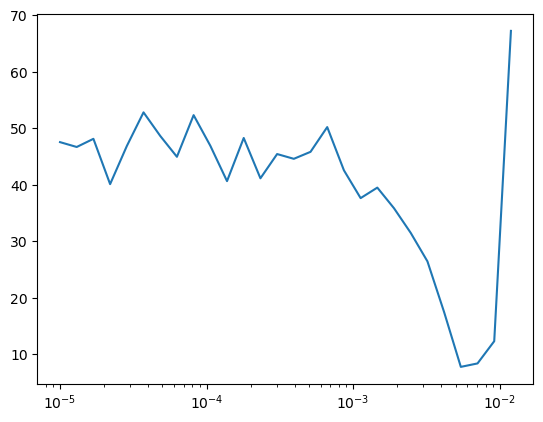

In [60]:
TrainLearner(get_model(), dls, loss_func=loss_func, cbs=cbs).lr_find()

TimeR2Score,loss,epoch,train,time
0.844,7.316,0,True,00:02
0.964,1.675,0,False,00:00
0.980,0.920,1,True,00:02
0.969,1.442,1,False,00:00


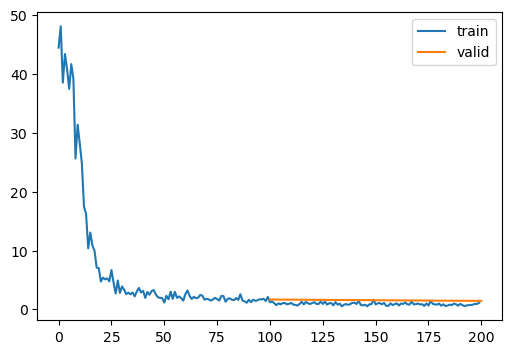

In [61]:
lr, epochs = 1e-3, 2
xtra = [get_sched(epochs, lr, dls)]
learn = TrainLearner(get_model(), dls, lr=lr, loss_func=loss_func, cbs=cbs)
learn.fit(epochs)

## Ensemble

In [62]:
from functools import partial

In [63]:
class CapturePreds(Callback):
    def before_fit(self, learn): self.all_input, self.all_preds, self.all_targs = [], [], []

    def after_batch(self, learn):
        self.all_input.append(to_cpu(learn.batch[0]))
        self.all_preds.append(to_cpu(learn.preds))
        self.all_targs.append(to_cpu(learn.batch[1]))

    def after_fit(self, learn):
        self.all_input, self.all_preds, self.all_targs = map(torch.cat, [self.all_input, self.all_preds, self.all_targs])

In [64]:
def ensemble_model(nlearn, get_model = get_model, tst_dls=tst_dls, epochs=5, lr=.03, loss_func=loss_func, cbs=cbs, opt_func=optim.SGD, metric_fn=metric_fn):
    learners = [TrainLearner(get_model(), dls, lr=lr, loss_func=loss_func, cbs=cbs, opt_func=opt_func) for _ in range(nlearn)]
    print('Training models')
    for learn in learners:
        learn.fit(epochs)
    cps = [CapturePreds() for _ in range(nlearn)]
    print('Making inference on test data')
    for dl_name, tst_dl in tst_dls.items():
        for learn, cp in zip(learners, cps):
            learn.dls = DataLoaders((), tst_dl)
            learn.fit(1, train=False, cbs=cp)
        ap = torch.stack([cp.all_preds for cp in cps]).mean(0)
        metric = metric_fn()
        metric.update(ap, cps[0].all_targs)
        print(f'Inference on {dl_name}')
        print('\t\tpreds, targs')
        print(torch.concat([ap, cps[0].all_targs], dim=1))
        print('result: ', metric.compute())

In [65]:
nlearn = 2

Training models


TimeR2Score,loss,epoch,train,time
0.824,8.239,0,True,00:02
0.965,1.616,0,False,00:00
0.979,0.986,1,True,00:02
0.970,1.386,1,False,00:00


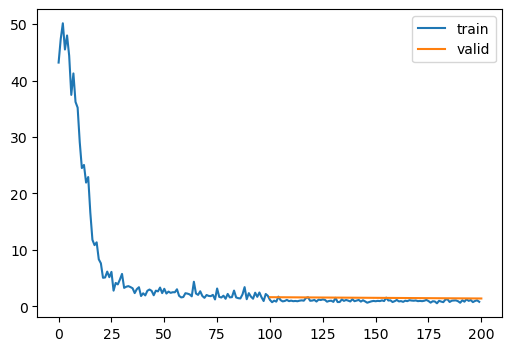

TimeR2Score,loss,epoch,train,time
0.826,8.182,0,True,00:02
0.966,1.648,0,False,00:00
0.980,0.928,1,True,00:02
0.970,1.429,1,False,00:00


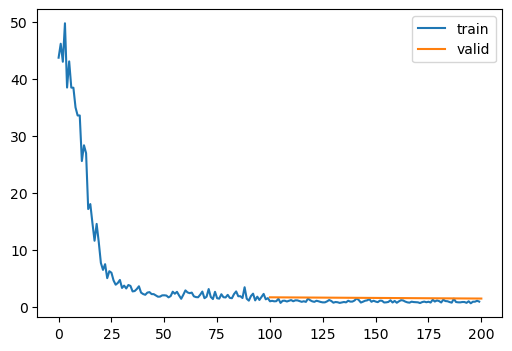

Making inference on test data


TimeR2Score,loss,epoch,train,time
0.754,11.494,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.710,13.556,0,False,00:00


Inference on nascent
		preds, targs
tensor([[ 4.9890,  0.0000],
        [ 6.0666,  4.0000],
        [ 9.8263,  8.0000],
        [10.8710, 12.0000],
        [13.4576, 16.0000],
        [19.4136, 20.0000],
        [ 8.5340,  0.0000],
        [ 2.5354,  4.0000],
        [11.5608,  8.0000],
        [10.5335, 12.0000],
        [19.7833, 16.0000],
        [21.9432, 20.0000]])
result:  tensor(0.7349)


TimeR2Score,loss,epoch,train,time
0.619,18.003,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.700,14.181,0,False,00:00


Inference on gro
		preds, targs
tensor([[11.6871,  1.0000],
        [ 4.2073,  4.0000],
        [ 8.9618,  7.0000],
        [10.0401, 10.0000],
        [13.3782, 13.0000],
        [14.0859, 16.0000],
        [18.9493, 19.0000],
        [19.6154, 22.0000]])
result:  tensor(0.6624)


TimeR2Score,loss,epoch,train,time
0.702,13.886,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.759,11.253,0,False,00:00


Inference on rna
		preds, targs
tensor([[ 4.9640,  2.0000],
        [ 9.6432,  6.0000],
        [ 9.2111, 10.0000],
        [12.7288, 14.0000],
        [19.3398, 18.0000],
        [20.7746, 22.0000],
        [ 6.9753,  2.0000],
        [ 9.3815,  6.0000],
        [10.9146, 10.0000],
        [12.6055, 14.0000],
        [19.1975, 18.0000],
        [12.9757, 22.0000]])
result:  tensor(0.7332)


TimeR2Score,loss,epoch,train,time
0.501,33.929,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.560,34.914,0,False,00:00


Inference on hepa
		preds, targs
tensor([[19.8319,  1.0000],
        [17.4360,  1.0000],
        [13.8909,  1.0000],
        [ 8.3106,  4.0000],
        [ 9.9272,  4.0000],
        [ 9.9547,  4.0000],
        [ 8.5847,  7.0000],
        [ 9.2864,  7.0000],
        [ 8.0362,  7.0000],
        [ 9.9845, 10.0000],
        [ 8.3902, 10.0000],
        [ 9.3631, 10.0000],
        [11.5786, 13.0000],
        [10.3196, 13.0000],
        [10.5745, 13.0000],
        [13.7388, 16.0000],
        [13.1804, 16.0000],
        [13.8815, 16.0000],
        [17.3446, 19.0000],
        [15.8777, 19.0000],
        [16.4153, 19.0000],
        [18.6457, 22.0000],
        [19.2363, 22.0000],
        [19.8359, 22.0000],
        [12.3666,  1.0000],
        [11.9233,  1.0000],
        [11.2192,  1.0000],
        [ 7.9599,  4.0000],
        [ 7.0525,  4.0000],
        [ 2.9628,  4.0000],
        [ 3.1258,  7.0000],
        [ 3.3223,  7.0000],
        [ 6.9634,  7.0000],
        [ 8.6734, 10.0000],
        [ 7.228

TimeR2Score,loss,epoch,train,time
0.409,311.225,0,False,00:03


TimeR2Score,loss,epoch,train,time
0.416,313.776,0,False,00:02


Inference on more
		preds, targs
tensor([[25.0000, 22.0000],
        [25.0000, 22.0000],
        [25.0000, 10.0000],
        ...,
        [-1.0000, 19.5000],
        [12.0000,  7.5000],
        [12.0000, 13.5000]])
result:  tensor(0.4211)


In [66]:
ensemble_model(nlearn, epochs=2, cbs=cbs, lr=1e-3, loss_func=loss_func)

In [67]:
def init_params(m, leaky=0.):
    if isinstance(m, (nn.Linear, nn.Conv2d)): init.kaiming_normal_(m.weight, a=leaky)

## Batchnorm

In [68]:
def get_model():
    return nn.Sequential(*[
    nn.Linear(len(indep_cols), 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Dropout(.2),
    nn.Linear(100, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Dropout(.2),
    nn.Linear(100, 1),
    nn.BatchNorm1d(1),
    TimeLayer()
]).apply(init_params)

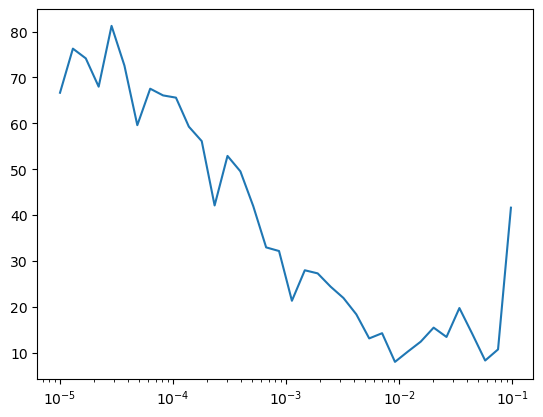

In [69]:
TrainLearner(get_model(), dls, loss_func, cbs=DeviceCB()).lr_find()

Training models


TimeR2Score,loss,epoch,train,time
0.894,5.553,0,True,00:03
0.932,3.522,0,False,00:00
0.930,3.494,1,True,00:02
0.954,2.458,1,False,00:00
0.962,1.779,2,True,00:02
0.967,1.651,2,False,00:00
0.976,1.105,3,True,00:02
0.976,1.245,3,False,00:00


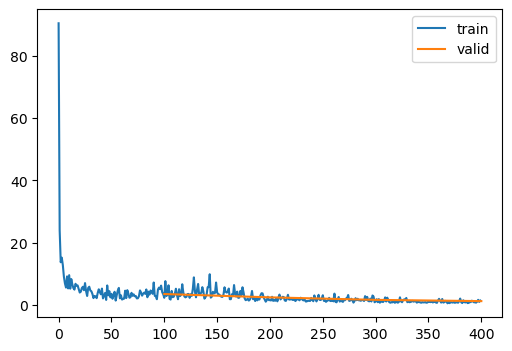

TimeR2Score,loss,epoch,train,time
0.894,5.531,0,True,00:02
0.919,4.404,0,False,00:00
0.940,2.969,1,True,00:02
0.962,1.965,1,False,00:00
0.963,1.780,2,True,00:02
0.974,1.342,2,False,00:00
0.977,1.073,3,True,00:02
0.975,1.365,3,False,00:00


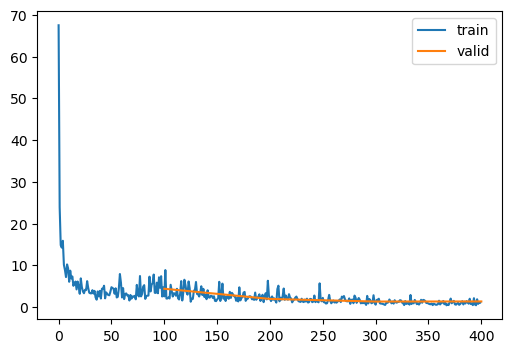

Making inference on test data


TimeR2Score,loss,epoch,train,time
0.820,8.392,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.821,8.334,0,False,00:00


Inference on nascent
		preds, targs
tensor([[ 1.9220,  0.0000],
        [ 5.4140,  4.0000],
        [ 7.3752,  8.0000],
        [10.0806, 12.0000],
        [14.4635, 16.0000],
        [18.1997, 20.0000],
        [ 7.2633,  0.0000],
        [ 2.3579,  4.0000],
        [10.4258,  8.0000],
        [10.2041, 12.0000],
        [20.3720, 16.0000],
        [20.6152, 20.0000]])
result:  tensor(0.8225)


TimeR2Score,loss,epoch,train,time
0.733,12.638,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.822,8.406,0,False,00:00


Inference on gro
		preds, targs
tensor([[ 9.5122,  1.0000],
        [ 4.2112,  4.0000],
        [ 7.2077,  7.0000],
        [ 9.2107, 10.0000],
        [13.3001, 13.0000],
        [14.2247, 16.0000],
        [18.7381, 19.0000],
        [19.5278, 22.0000]])
result:  tensor(0.7815)


TimeR2Score,loss,epoch,train,time
0.728,15.914,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.789,16.887,0,False,00:00


Inference on rna
		preds, targs
tensor([[ 2.3851,  2.0000],
        [ 7.1588,  6.0000],
        [ 9.1113, 10.0000],
        [13.8646, 14.0000],
        [19.2436, 18.0000],
        [20.9613, 22.0000],
        [ 3.1814,  2.0000],
        [ 7.4622,  6.0000],
        [10.2461, 10.0000],
        [11.0874, 14.0000],
        [19.1502, 18.0000],
        [ 8.7177, 22.0000]])
result:  tensor(0.7622)


TimeR2Score,loss,epoch,train,time
0.498,49.222,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.546,39.881,0,False,00:00


Inference on hepa
		preds, targs
tensor([[20.0469,  1.0000],
        [19.0856,  1.0000],
        [13.8359,  1.0000],
        [ 9.5738,  4.0000],
        [10.6235,  4.0000],
        [11.3576,  4.0000],
        [ 7.1731,  7.0000],
        [ 6.9023,  7.0000],
        [ 6.8689,  7.0000],
        [ 8.9980, 10.0000],
        [ 7.9358, 10.0000],
        [ 7.9156, 10.0000],
        [10.2332, 13.0000],
        [ 9.8879, 13.0000],
        [10.1443, 13.0000],
        [13.2710, 16.0000],
        [10.9894, 16.0000],
        [13.4869, 16.0000],
        [15.4300, 19.0000],
        [15.7950, 19.0000],
        [16.9300, 19.0000],
        [17.3453, 22.0000],
        [18.0210, 22.0000],
        [19.4561, 22.0000],
        [13.2287,  1.0000],
        [15.6297,  1.0000],
        [15.4061,  1.0000],
        [ 5.4379,  4.0000],
        [ 6.0108,  4.0000],
        [ 1.5771,  4.0000],
        [ 2.7622,  7.0000],
        [ 2.8343,  7.0000],
        [ 5.3643,  7.0000],
        [ 7.8622, 10.0000],
        [ 5.140

TimeR2Score,loss,epoch,train,time
0.387,312.732,0,False,00:03


TimeR2Score,loss,epoch,train,time
0.411,297.326,0,False,00:03


Inference on more
		preds, targs
tensor([[24.9706, 22.0000],
        [25.0000, 22.0000],
        [ 3.2334, 10.0000],
        ...,
        [-1.0000, 19.5000],
        [-1.0000,  7.5000],
        [-1.0000, 13.5000]])
result:  tensor(0.4022)


In [70]:
lr, epochs = .2, 4
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

Training models


TimeR2Score,loss,epoch,train,time
0.894,5.502,0,True,00:02
0.933,3.724,0,False,00:00
0.950,2.456,1,True,00:03
0.966,1.680,1,False,00:00
0.969,1.461,2,True,00:03
0.978,1.232,2,False,00:00
0.979,0.977,3,True,00:02
0.981,1.133,3,False,00:00


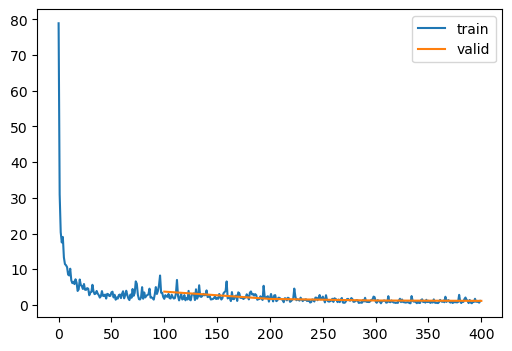

TimeR2Score,loss,epoch,train,time
0.891,5.661,0,True,00:02
0.953,2.490,0,False,00:00
0.948,2.542,1,True,00:02
0.966,2.162,1,False,00:00
0.969,1.457,2,True,00:02
0.977,1.229,2,False,00:00
0.980,0.951,3,True,00:02
0.979,1.096,3,False,00:00


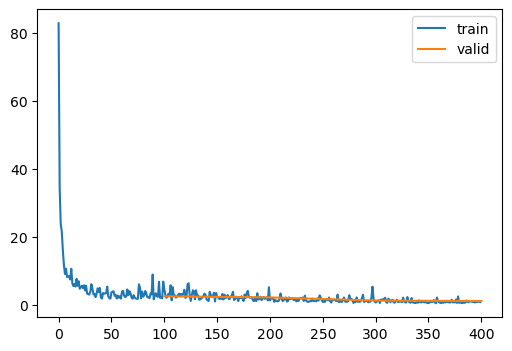

Making inference on test data


TimeR2Score,loss,epoch,train,time
0.782,10.183,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.808,8.941,0,False,00:00


Inference on nascent
		preds, targs
tensor([[ 2.3633,  0.0000],
        [ 6.0277,  4.0000],
        [ 7.2966,  8.0000],
        [10.0774, 12.0000],
        [13.7334, 16.0000],
        [18.6853, 20.0000],
        [ 7.7763,  0.0000],
        [ 2.6732,  4.0000],
        [10.9524,  8.0000],
        [10.4502, 12.0000],
        [20.4731, 16.0000],
        [20.3619, 20.0000]])
result:  tensor(0.7960)


TimeR2Score,loss,epoch,train,time
0.684,14.932,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.950,2.373,0,False,00:00


Inference on gro
		preds, targs
tensor([[ 7.8052,  1.0000],
        [ 5.8126,  4.0000],
        [ 7.5494,  7.0000],
        [ 9.6838, 10.0000],
        [13.7529, 13.0000],
        [14.4882, 16.0000],
        [18.8370, 19.0000],
        [20.1139, 22.0000]])
result:  tensor(0.8507)


TimeR2Score,loss,epoch,train,time
0.884,5.410,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.905,4.444,0,False,00:00


Inference on rna
		preds, targs
tensor([[ 2.6605,  2.0000],
        [ 7.3599,  6.0000],
        [ 9.5106, 10.0000],
        [13.8569, 14.0000],
        [18.9978, 18.0000],
        [21.2242, 22.0000],
        [ 5.4691,  2.0000],
        [ 7.0024,  6.0000],
        [10.1901, 10.0000],
        [11.3262, 14.0000],
        [19.7877, 18.0000],
        [16.5177, 22.0000]])
result:  tensor(0.8971)


TimeR2Score,loss,epoch,train,time
0.600,44.118,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.556,43.446,0,False,00:00


Inference on hepa
		preds, targs
tensor([[20.4476,  1.0000],
        [18.8926,  1.0000],
        [15.4334,  1.0000],
        [ 5.8886,  4.0000],
        [ 9.4182,  4.0000],
        [14.0152,  4.0000],
        [ 6.8327,  7.0000],
        [ 7.2966,  7.0000],
        [ 7.2546,  7.0000],
        [ 9.9143, 10.0000],
        [ 8.7330, 10.0000],
        [ 8.2599, 10.0000],
        [10.4960, 13.0000],
        [10.2133, 13.0000],
        [10.1936, 13.0000],
        [13.5546, 16.0000],
        [11.8961, 16.0000],
        [13.8248, 16.0000],
        [15.5584, 19.0000],
        [16.7134, 19.0000],
        [16.3859, 19.0000],
        [17.2921, 22.0000],
        [18.3345, 22.0000],
        [19.4295, 22.0000],
        [15.5445,  1.0000],
        [15.7181,  1.0000],
        [15.1388,  1.0000],
        [ 5.7015,  4.0000],
        [ 5.7498,  4.0000],
        [ 1.7176,  4.0000],
        [ 3.8897,  7.0000],
        [ 3.4755,  7.0000],
        [ 5.7067,  7.0000],
        [ 7.7654, 10.0000],
        [ 5.600

TimeR2Score,loss,epoch,train,time
0.414,290.475,0,False,00:03


TimeR2Score,loss,epoch,train,time
0.402,310.437,0,False,00:03


Inference on more
		preds, targs
tensor([[24.9240, 22.0000],
        [24.9993, 22.0000],
        [ 8.3347, 10.0000],
        ...,
        [-1.0000, 19.5000],
        [-1.0000,  7.5000],
        [-1.0000, 13.5000]])
result:  tensor(0.4177)


In [71]:
lr, epochs = .1, 4
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

Training models


TimeR2Score,loss,epoch,train,time
0.903,5.060,0,True,00:02
0.935,3.909,0,False,00:00
0.929,3.575,1,True,00:02
0.947,3.176,1,False,00:00
0.947,2.635,2,True,00:02
0.954,2.735,2,False,00:00
0.964,1.708,3,True,00:02
0.975,1.441,3,False,00:00
0.977,1.058,4,True,00:02
0.978,1.260,4,False,00:00


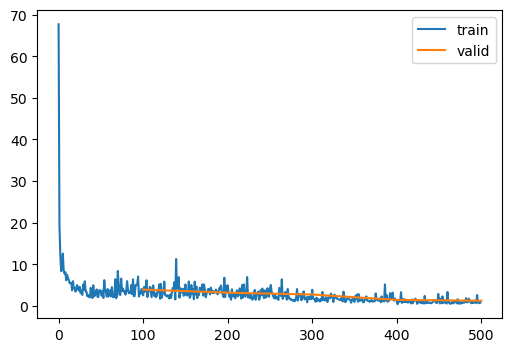

TimeR2Score,loss,epoch,train,time
0.885,5.940,0,True,00:02
0.867,6.740,0,False,00:00
0.919,4.168,1,True,00:02
0.952,2.562,1,False,00:00
0.953,2.263,2,True,00:02
0.962,1.845,2,False,00:00
0.969,1.451,3,True,00:02
0.976,1.161,3,False,00:00
0.979,0.982,4,True,00:02
0.978,1.043,4,False,00:00


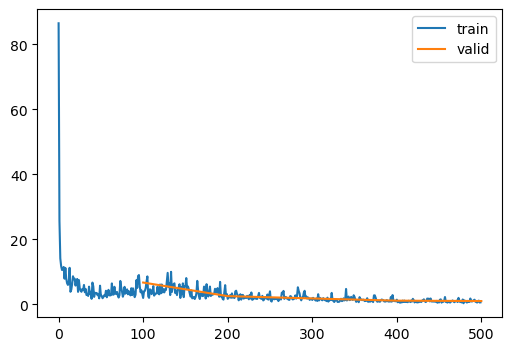

Making inference on test data


TimeR2Score,loss,epoch,train,time
0.840,7.459,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.843,7.304,0,False,00:00


Inference on nascent
		preds, targs
tensor([[ 2.4755,  0.0000],
        [ 5.6133,  4.0000],
        [ 7.5066,  8.0000],
        [ 9.7266, 12.0000],
        [13.7503, 16.0000],
        [18.2652, 20.0000],
        [ 6.0845,  0.0000],
        [ 3.2711,  4.0000],
        [11.1991,  8.0000],
        [10.5105, 12.0000],
        [19.8935, 16.0000],
        [20.4826, 20.0000]])
result:  tensor(0.8436)


TimeR2Score,loss,epoch,train,time
0.826,8.201,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.842,38.338,0,False,00:00


Inference on gro
		preds, targs
tensor([[12.9390,  1.0000],
        [ 6.0103,  4.0000],
        [ 7.6334,  7.0000],
        [ 9.0664, 10.0000],
        [13.4714, 13.0000],
        [14.1404, 16.0000],
        [18.4364, 19.0000],
        [19.4550, 22.0000]])
result:  tensor(0.5811)


TimeR2Score,loss,epoch,train,time
0.790,9.822,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.848,7.074,0,False,00:00


Inference on rna
		preds, targs
tensor([[ 3.7464,  2.0000],
        [ 6.8283,  6.0000],
        [ 9.4565, 10.0000],
        [13.7278, 14.0000],
        [19.1043, 18.0000],
        [20.5892, 22.0000],
        [ 5.4489,  2.0000],
        [ 7.2203,  6.0000],
        [10.0996, 10.0000],
        [11.3983, 14.0000],
        [19.4739, 18.0000],
        [13.6279, 22.0000]])
result:  tensor(0.8219)


TimeR2Score,loss,epoch,train,time
0.579,41.824,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.587,39.367,0,False,00:00


Inference on hepa
		preds, targs
tensor([[20.1500,  1.0000],
        [18.6535,  1.0000],
        [15.5628,  1.0000],
        [ 8.1601,  4.0000],
        [ 8.9924,  4.0000],
        [10.2180,  4.0000],
        [ 7.0067,  7.0000],
        [ 6.8947,  7.0000],
        [ 6.9788,  7.0000],
        [10.1133, 10.0000],
        [ 8.7536, 10.0000],
        [ 9.0907, 10.0000],
        [11.1173, 13.0000],
        [10.0415, 13.0000],
        [10.6167, 13.0000],
        [13.5712, 16.0000],
        [12.0335, 16.0000],
        [13.8954, 16.0000],
        [16.4589, 19.0000],
        [16.2914, 19.0000],
        [15.7329, 19.0000],
        [18.5805, 22.0000],
        [18.7468, 22.0000],
        [18.1264, 22.0000],
        [14.1489,  1.0000],
        [12.8654,  1.0000],
        [14.3740,  1.0000],
        [ 8.0690,  4.0000],
        [ 7.0533,  4.0000],
        [ 1.8133,  4.0000],
        [ 3.4279,  7.0000],
        [ 3.5161,  7.0000],
        [ 6.4468,  7.0000],
        [ 7.8139, 10.0000],
        [ 6.441

TimeR2Score,loss,epoch,train,time
0.412,301.129,0,False,00:03


TimeR2Score,loss,epoch,train,time
0.394,307.164,0,False,00:03


Inference on more
		preds, targs
tensor([[16.0296, 22.0000],
        [22.0696, 22.0000],
        [11.9774, 10.0000],
        ...,
        [-1.0000, 19.5000],
        [-0.9999,  7.5000],
        [-0.9997, 13.5000]])
result:  tensor(0.4024)


In [72]:
lr, epochs = .3, 5
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

Training models


TimeR2Score,loss,epoch,train,time
0.894,5.141,0,True,00:03
0.958,2.455,0,False,00:00
0.950,2.433,1,True,00:03
0.956,2.359,1,False,00:00
0.964,1.730,2,True,00:03
0.971,1.421,2,False,00:00
0.974,1.202,3,True,00:02
0.980,1.104,3,False,00:00
0.981,0.877,4,True,00:03
0.983,0.952,4,False,00:00


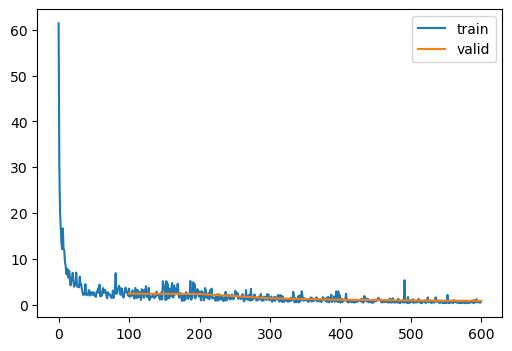

TimeR2Score,loss,epoch,train,time
0.891,5.538,0,True,00:03
0.956,2.331,0,False,00:00
0.949,2.522,1,True,00:03
0.958,2.397,1,False,00:00
0.960,1.967,2,True,00:04
0.971,1.463,2,False,00:00
0.971,1.340,3,True,00:04
0.972,1.375,3,False,00:01
0.979,1.012,4,True,00:04
0.982,0.904,4,False,00:00


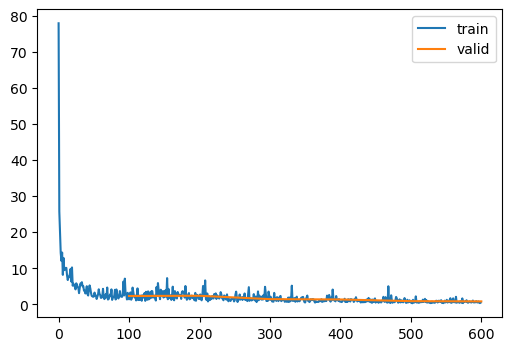

Making inference on test data


TimeR2Score,loss,epoch,train,time
0.830,7.926,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.802,9.220,0,False,00:00


Inference on nascent
		preds, targs
tensor([[ 2.9263,  0.0000],
        [ 5.7451,  4.0000],
        [ 7.0154,  8.0000],
        [10.1844, 12.0000],
        [13.8828, 16.0000],
        [18.4534, 20.0000],
        [ 6.9144,  0.0000],
        [ 3.3435,  4.0000],
        [11.2357,  8.0000],
        [10.5880, 12.0000],
        [20.3260, 16.0000],
        [20.1921, 20.0000]])
result:  tensor(0.8175)


TimeR2Score,loss,epoch,train,time
0.654,16.330,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.886,5.396,0,False,00:00


Inference on gro
		preds, targs
tensor([[ 9.1085,  1.0000],
        [ 5.2697,  4.0000],
        [ 7.0464,  7.0000],
        [ 9.1517, 10.0000],
        [13.8174, 13.0000],
        [14.8271, 16.0000],
        [18.3244, 19.0000],
        [19.2377, 22.0000]])
result:  tensor(0.7931)


TimeR2Score,loss,epoch,train,time
0.826,8.129,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.889,5.165,0,False,00:00


Inference on rna
		preds, targs
tensor([[ 2.2780,  2.0000],
        [ 7.4720,  6.0000],
        [ 9.6491, 10.0000],
        [14.0878, 14.0000],
        [19.3804, 18.0000],
        [20.8713, 22.0000],
        [ 3.4154,  2.0000],
        [ 6.5964,  6.0000],
        [10.2412, 10.0000],
        [11.2616, 14.0000],
        [19.7341, 18.0000],
        [14.3877, 22.0000]])
result:  tensor(0.8635)


TimeR2Score,loss,epoch,train,time
0.626,42.231,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.511,40.112,0,False,00:00


Inference on hepa
		preds, targs
tensor([[19.8886,  1.0000],
        [18.7390,  1.0000],
        [16.2891,  1.0000],
        [ 6.6846,  4.0000],
        [ 9.2169,  4.0000],
        [11.1379,  4.0000],
        [ 6.6331,  7.0000],
        [ 7.2629,  7.0000],
        [ 6.8618,  7.0000],
        [ 9.9433, 10.0000],
        [ 9.0001, 10.0000],
        [ 8.3305, 10.0000],
        [10.6374, 13.0000],
        [10.0458, 13.0000],
        [10.4647, 13.0000],
        [13.7760, 16.0000],
        [12.0248, 16.0000],
        [14.1203, 16.0000],
        [15.4250, 19.0000],
        [15.9736, 19.0000],
        [16.7594, 19.0000],
        [18.0766, 22.0000],
        [17.9147, 22.0000],
        [18.9844, 22.0000],
        [14.0239,  1.0000],
        [15.1943,  1.0000],
        [13.8939,  1.0000],
        [ 7.3205,  4.0000],
        [ 7.1198,  4.0000],
        [ 2.0869,  4.0000],
        [ 3.8597,  7.0000],
        [ 3.4088,  7.0000],
        [ 6.1873,  7.0000],
        [ 8.6257, 10.0000],
        [ 6.956

TimeR2Score,loss,epoch,train,time
0.397,308.032,0,False,00:06


TimeR2Score,loss,epoch,train,time
0.415,293.802,0,False,00:05


Inference on more
		preds, targs
tensor([[20.1435, 22.0000],
        [25.0000, 22.0000],
        [-0.9991, 10.0000],
        ...,
        [-1.0000, 19.5000],
        [-1.0000,  7.5000],
        [-1.0000, 13.5000]])
result:  tensor(0.4125)


In [73]:
lr, epochs = .1, 6
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

In [81]:
torch.set_printoptions(edgeitems=15, linewidth=100)

Training models


TimeR2Score,loss,epoch,train,time
0.875,6.683,0,True,00:02
0.940,3.050,0,False,00:00


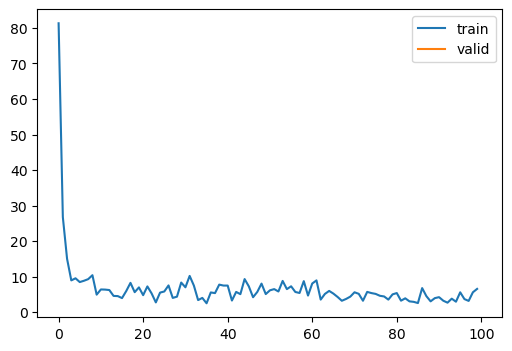

TimeR2Score,loss,epoch,train,time
0.894,5.542,0,True,00:02
0.952,2.381,0,False,00:00


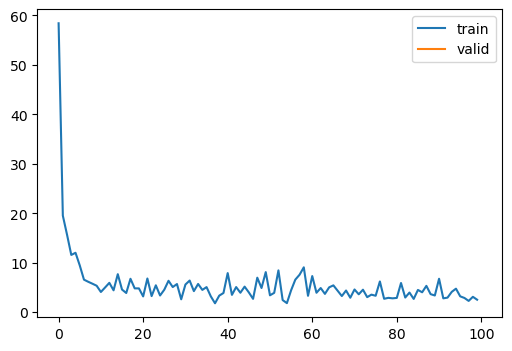

Making inference on test data


TimeR2Score,loss,epoch,train,time
0.767,10.859,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.753,11.536,0,False,00:00


Inference on nascent
		preds, targs
tensor([[ 5.0710,  0.0000],
        [ 5.6301,  4.0000],
        [ 8.1913,  8.0000],
        [10.1975, 12.0000],
        [12.1877, 16.0000],
        [19.7768, 20.0000],
        [ 5.6664,  0.0000],
        [ 1.7540,  4.0000],
        [11.8199,  8.0000],
        [10.9755, 12.0000],
        [21.6526, 16.0000],
        [21.2742, 20.0000]])
result:  tensor(0.7632)


TimeR2Score,loss,epoch,train,time
0.968,1.516,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.736,12.464,0,False,00:00


Inference on gro
		preds, targs
tensor([[ 7.1412,  1.0000],
        [ 3.9866,  4.0000],
        [ 8.0506,  7.0000],
        [ 8.9522, 10.0000],
        [13.3545, 13.0000],
        [15.4135, 16.0000],
        [19.2494, 19.0000],
        [20.5119, 22.0000]])
result:  tensor(0.8871)


TimeR2Score,loss,epoch,train,time
0.630,17.277,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.904,4.474,0,False,00:00


Inference on rna
		preds, targs
tensor([[ 3.2796,  2.0000],
        [ 7.8484,  6.0000],
        [ 8.9080, 10.0000],
        [13.8475, 14.0000],
        [20.2191, 18.0000],
        [21.7589, 22.0000],
        [ 4.3899,  2.0000],
        [ 7.7940,  6.0000],
        [11.4724, 10.0000],
        [11.7939, 14.0000],
        [20.9239, 18.0000],
        [13.3141, 22.0000]])
result:  tensor(0.8014)


TimeR2Score,loss,epoch,train,time
0.443,42.765,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.445,45.806,0,False,00:00


Inference on hepa
		preds, targs
tensor([[18.5454,  1.0000],
        [18.3944,  1.0000],
        [16.5098,  1.0000],
        [ 9.3388,  4.0000],
        [11.8937,  4.0000],
        [16.4877,  4.0000],
        [ 8.0146,  7.0000],
        [ 7.4515,  7.0000],
        [ 7.1971,  7.0000],
        [ 9.5409, 10.0000],
        [ 8.6718, 10.0000],
        [ 8.3834, 10.0000],
        [11.3277, 13.0000],
        [10.5307, 13.0000],
        [11.2291, 13.0000],
        [13.2739, 16.0000],
        [12.5529, 16.0000],
        [14.8188, 16.0000],
        [16.5011, 19.0000],
        [17.5144, 19.0000],
        [16.6399, 19.0000],
        [18.9706, 22.0000],
        [19.5085, 22.0000],
        [20.0674, 22.0000],
        [12.7000,  1.0000],
        [13.9532,  1.0000],
        [14.6288,  1.0000],
        [ 6.5847,  4.0000],
        [ 5.0470,  4.0000],
        [ 1.3058,  4.0000],
        [ 2.4353,  7.0000],
        [ 2.5831,  7.0000],
        [ 5.1121,  7.0000],
        [ 5.9568, 10.0000],
        [ 4.245

TimeR2Score,loss,epoch,train,time
0.392,319.874,0,False,00:03


TimeR2Score,loss,epoch,train,time
0.395,326.471,0,False,00:03


Inference on more
		preds, targs
tensor([[12.0003, 22.0000],
        [25.0000, 22.0000],
        [-1.0000, 10.0000],
        [-0.9996, 18.0000],
        [12.0000,  2.0000],
        [-0.9999, 18.0000],
        [-0.9998, 14.0000],
        [12.0000,  6.0000],
        [12.0001,  6.0000],
        [-0.9999, 14.0000],
        [-0.9999, 10.0000],
        [-0.9978,  2.0000],
        [-1.0000, 24.0000],
        [-1.0000, 21.0000],
        [-1.0000, 33.0000],
        ...,
        [-1.0000,  7.5000],
        [-1.0000,  1.5000],
        [-1.0000, 16.5000],
        [-1.0000,  4.5000],
        [-1.0000, 22.5000],
        [-1.0000, 16.5000],
        [-1.0000,  1.5000],
        [-1.0000, 10.5000],
        [-1.0000, 16.5000],
        [-1.0000,  1.5000],
        [-1.0000, 13.5000],
        [-0.9200,  7.5000],
        [-1.0000, 19.5000],
        [-1.0000,  7.5000],
        [-1.0000, 13.5000]])
result:  tensor(0.3684)


In [82]:
lr, epochs = .3, 1
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

## Conclusion

Unfortunately, deeper network did not perform better on bulk data than shallower network even if they did better on scRNA-seq data. Maybe because the training data is too noisy with random numbers.